# This code generates a Fourier transform of a specified shape as outlined in Timmer and Koenig 1995 (A&A vol 300 p 707-710), and plots it and its corresponding time series. The user can specify a mean count rate for the light curve, fractional rms^2 variance for the power spectrum, and 'Poissonify' the light curve.

##### by Abigail Stevens, A.L.Stevens at uva.nl

In [1]:
import numpy as np
from scipy import fftpack
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.font_manager as font_manager
import itertools

## Shows the plots inline, instead of in a separate window:
%matplotlib inline

## Sets the font size for plotting
font_prop = font_manager.FontProperties(size=18)

def power_of_two(num):
    ## Checks if an input is a power of 2 (1 <= num < 2147483648).
    n = int(num)
    x = 2
    assert n > 0, "ERROR: Number must be positive."
    if n == 1:
        return True
    else: 
        while x < n and x < 2147483648:
            x *= 2
        return n == x
    

### Define a function to make a pulsation light curve

In [2]:
def make_pulsation(n_bins, dt, freq, amp, mean, phase):
    binning = 10
    period = 1.0 / freq  # in seconds
    bins_per_period = period / dt
    tiny_bins = np.arange(0, n_bins, 1.0/binning)
    smooth_sine = amp * np.sin(2.0 * np.pi * tiny_bins / bins_per_period + phase) + mean
    time_series = np.mean(np.array_split(smooth_sine, n_bins), axis=1)

    return time_series

### Define a function to re-bin a power spectrum in frequency by a specified constant > 1.

In [3]:
def geometric_rebinning(freq, power, rebin_const):
    """
            geometric_rebinning
            
    Re-bins the power spectrum in frequency space by some re-binning constant (rebin_const > 1). 

    """
    
    ## Initializing variables
    rb_power = np.asarray([])  # List of re-binned power
    rb_freq = np.asarray([]) # List of re-binned frequencies
    real_index = 1.0 # The unrounded next index in power
    int_index = 1 # The int of real_index, added to current_m every iteration
    current_m = 1 # Current index in power
    prev_m = 0 # Previous index m
    bin_power = 0.0 # The power of the current re-binned bin
    bin_freq = 0.0 # The frequency of the current re-binned bin
    bin_range = 0.0           # The range of un-binned bins covered by this re-binned bin
    freq_min = np.asarray([])
    freq_max = np.asarray([])
    
    ## Looping through the length of the array power, geometric bin by geometric bin, 
    ## to compute the average power and frequency of that geometric bin.
    ## Equations for frequency, power, and error are from Adam Ingram's PhD thesis.
    while current_m < len(power):
#     while current_m < 100: # used for debugging

        ## Initializing clean variables for each iteration of the while-loop
        bin_power = 0.0  # the averaged power at each index of rb_power
        bin_range = 0.0
        bin_freq = 0.0
        
        ## Determining the range of indices this specific geometric bin covers
        bin_range = np.absolute(current_m - prev_m)
        ## Want mean of data points contained within one geometric bin
        bin_power = np.mean(power[prev_m:current_m])
        
        ## Computing the mean frequency of a geometric bin
        bin_freq = np.mean(freq[prev_m:current_m])
        
        ## Appending values to arrays
        rb_power = np.append(rb_power, bin_power)
        rb_freq = np.append(rb_freq, bin_freq)
        freq_min = np.append(freq_min, freq[prev_m])
        freq_max = np.append(freq_max, freq[current_m])
        
        ## Incrementing for the next iteration of the loop
        ## Since the for-loop goes from prev_m to current_m-1 (since that's how
        ## the range function and array slicing works) it's ok that we set 
        ## prev_m = current_m here for the next round. This will not cause any
        ## double-counting bins or skipping bins.
        prev_m = current_m
        real_index *= rebin_const
        int_index = int(round(real_index))
        current_m += int_index
        bin_range = None
        bin_freq = None
        bin_power = None
    ## End of while-loop

    return rb_freq, rb_power, freq_min, freq_max
## End of function 'geometric_rebinning'

### Define functions to make different power spectral shapes: power law, Lorentzian, Gaussian, power law with exponential decay, broken power law

In [4]:
def powerlaw(w, beta):
    ## Gives a powerlaw of (1/w)^beta
    pl = np.zeros(len(w))
    pl[1:] = w[1:] ** (beta)
    pl[0] = np.inf
    return pl

def lorentzian(w, w_0, gamma):
    ## Gives a Lorentzian centered on w_0 with a FWHM of gamma
    numerator = gamma / (np.pi * 2.0)
    denominator = (w - w_0) ** 2 + (1.0/2.0 * gamma) ** 2
    L = numerator / denominator
    return L

def gaussian(w, mean, std_dev):
    ## Gives a Gaussian with a mean of mean and a standard deviation of std_dev
    ## FWHM = 2 * np.sqrt(2 * np.log(2))*std_dev
    exp_numerator = -(w - mean)**2
    exp_denominator = 2 * std_dev**2
    G = np.exp(exp_numerator / exp_denominator)
    return G

def powerlaw_expdecay(w, beta, alpha):
    pl_exp = np.where(w != 0, (1.0 / w) ** beta * np.exp(-alpha * w), np.inf) 
    return pl_exp

def broken_powerlaw(w, w_b, beta_1, beta_2):
    c = w_b ** (-beta_1 + beta_2)  ## scale factor so that they're equal at the break frequency
    pl_1 = w[np.where(w <= w_b)] ** (-beta_1)
    pl_2 = c * w[np.where(w > w_b)] ** (-beta_2)
    pl = np.append(pl_1, pl_2)
    return pl

### Defining functions for applying an inverse fractional rms^2 and inverse Leahy normalization to the noise psd shape

In [5]:
def inv_frac_rms2_norm(amplitudes, dt, n_bins, mean_rate):
#     rms2_power = 2.0 * power * dt / float(n_bins) / (mean_rate ** 2)
    inv_rms2 = amplitudes * n_bins * (mean_rate ** 2) / 2.0 / dt
    return inv_rms2

def inv_leahy_norm(amplitudes, dt, n_bins, mean_rate):
#     leahy_power = 2.0 * power * dt / float(n_bins) / mean_rate
    inv_leahy = amplitudes * n_bins * mean_rate / 2.0 / dt
    return inv_leahy

### Define some basics: number of bins per segment, timestep between bins, and making the fourier frequencies.

In [15]:
n_bins = 8192
# n_bins = 64

dt = 64.0 / 8192.0 
print "dt = %.15f" % dt

df = 1.0 / dt / n_bins
# print df

assert power_of_two(n_bins), "ERROR: N_bins must be a power of 2 and an even integer."

## Making an array of Fourier frequencies
frequencies = np.arange(float(-n_bins/2)+1, float(n_bins/2)+1) * df
pos_freq = frequencies[np.where(frequencies >= 0)]
## positive should have 2 more than negative, because of the 0 freq and the nyquist freq
neg_freq = frequencies[np.where(frequencies < 0)]
nyquist = pos_freq[-1]

dt = 0.007812500000000


### Defining the psd shape of the noise

In [20]:
noise_psd_variance = 0.007  ## in fractional rms^2 units
# noise_mean_rate = 1000.0  ## in count rate units
noise_mean_rate = 500

beta = -1.0  ## Slope of power law (include negative here if needed)

## For a Lorentzian QPO
# w_0 = 5.46710256  ## Centroid frequency of QPO
# fwhm = 0.80653875  ## FWHM of QPO

## For a Gaussian QPO
w_0 = 5.4
# g_stddev = 0.473032436922
# fwhm = 2.0 * np.sqrt(2.0 * np.log(2.0)) * g_stddev
fwhm = 0.9

pl_scale = 0.08  ## relative scale factor
qpo_scale = 1.0  ## relative scale factor

Q = w_0 / fwhm ## For QPOs, Q factor is w_0 / gamma
print "Q =", Q

# noise_psd_shape = noise_psd_variance * powerlaw(pos_freq, beta)
noise_psd_shape = noise_psd_variance * (qpo_scale * lorentzian(pos_freq, w_0, fwhm) + pl_scale * powerlaw(pos_freq, beta))
# noise_psd_shape = noise_psd_variance * (qpo_scale * gaussian(pos_freq, w_0, g_stddev) + pl_scale * powerlaw(pos_freq, beta))
# noise_psd_shape = lorentzian(pos_freq, w_1, gamma_1) + lorentzian(pos_freq, w_2, gamma_2) + powerlaw(pos_freq, beta)
# noise_psd_shape = lorentzian(pos_freq, w_1, gamma_1) + lorentzian(pos_freq, w_2, gamma_2)
noise_psd_shape = inv_frac_rms2_norm(noise_psd_shape, dt, n_bins, noise_mean_rate)

Q = 6.0


### Generating a noise process with the specific shape noise_psd_shape

In [21]:
rand_r = np.random.standard_normal(len(pos_freq))
rand_i = np.random.standard_normal(len(pos_freq)-1)
rand_i = np.append(rand_i, 0.0) # because the nyquist frequency should only have a real value

## Creating the real and imaginary values from the lists of random numbers and the frequencies
r_values = rand_r * np.sqrt(0.5 * noise_psd_shape)
i_values = rand_i * np.sqrt(0.5 * noise_psd_shape)
r_values[np.where(pos_freq == 0)] = 0
i_values[np.where(pos_freq == 0)] = 0

## Combining to make the Fourier transform
FT_pos = r_values + i_values*1j
FT_neg = np.conj(FT_pos[1:-1]) 
FT_neg = FT_neg[::-1]  ## Need to flip direction of the negative frequency FT values so that they match up correctly
FT = np.append(FT_pos, FT_neg)

## Making the light curve from the Fourier transform and Poissonifying it
noise_lc = fftpack.ifft(FT).real + noise_mean_rate
noise_lc[np.where(noise_lc < 0)] = 0.0
# noise_lc_poiss = np.random.poisson(noise_lc * dt)
noise_lc_poiss = np.random.poisson(noise_lc * dt) / dt  

## Making the power spectrum from the Poissonified light curve
real_mean = np.mean(noise_lc_poiss)
noise_power = np.absolute(fftpack.fft(noise_lc_poiss - real_mean))**2
noise_power = noise_power[0:len(pos_freq)]

## Applying the fractional rms^2 normalization to the power spectrum
noise_power *= 2.0 * dt / float(n_bins) / (real_mean **2)
noise_level = 2.0 / real_mean
noise_power -= noise_level

## Re-binning the power spectrum in frequency
rb_freq, rb_power, freq_min, freq_max = geometric_rebinning(pos_freq, noise_power, 1.01)


### Plotting the noise process: light curve and power spectrum.

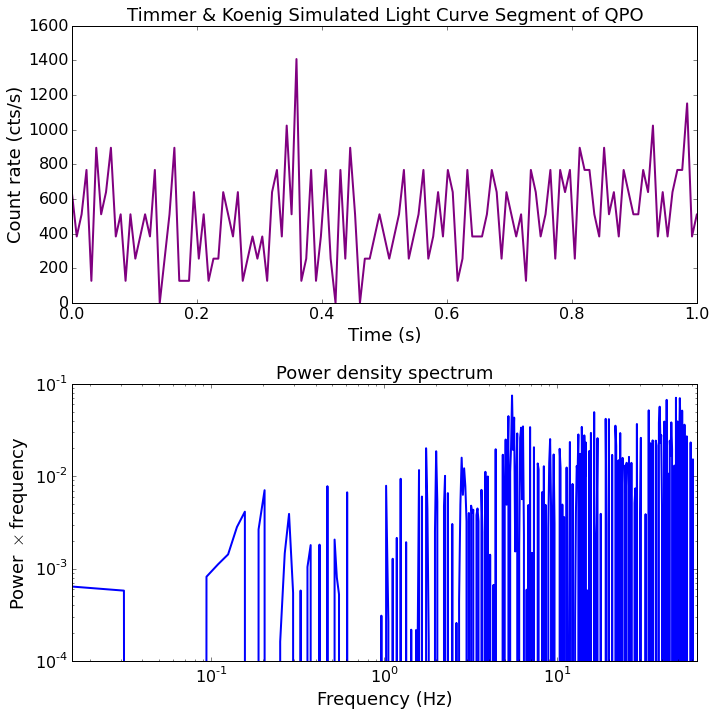

Q = 6.0
w_0 = 5.4
fwhm = 0.9
beta = -1.0


In [28]:
super_title_noise="Noise process"

npn_noise = rb_power * rb_freq
time_bins = np.arange(n_bins)
time = time_bins * dt

# fig, ax1 = plt.subplots(1, 1, figsize=(10,5))
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))
# fig.suptitle(super_title_noise, fontsize=20, y=1.03)

ax1.plot(time, noise_lc_poiss, linewidth=2.0, color='purple')
ax1.set_xlabel('Time (s)', fontproperties=font_prop)
ax1.set_ylabel('Count rate (cts/s)', fontproperties=font_prop)
# ax1.set_xlim(0,0.3)
ax1.set_xlim(np.min(time), np.max(time))
ax1.set_xlim(0,1)
# ax1.set_ylim(0,450)
ax1.tick_params(axis='x', labelsize=16, bottom=True, top=True, labelbottom=True, labeltop=False)
ax1.tick_params(axis='y', labelsize=16, left=True, right=True, labelleft=True, labelright=False)
# ax1.set_title('Light curve', fontproperties=font_prop)
ax1.set_title('Timmer & Koenig Simulated Light Curve Segment of QPO', fontproperties=font_prop)

# ax2.plot(pos_freq, pulse_power * pos_freq, linewidth=2.0)
ax2.plot(rb_freq, npn_noise, linewidth=2.0)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'Frequency (Hz)', fontproperties=font_prop)
ax2.set_ylabel(r'Power $\times$ frequency', fontproperties=font_prop)
ax2.set_xlim(0, nyquist)
# ax2.set_xlim(0,200)
# ax2.set_ylim(1e-5, 1e-1)
ax2.tick_params(axis='x', labelsize=16, bottom=True, top=True, labelbottom=True, labeltop=False)
ax2.tick_params(axis='y', labelsize=16, left=True, right=True, labelleft=True, labelright=False)
ax2.set_title('Power density spectrum', fontproperties=font_prop)

fig.tight_layout(pad=1.0, h_pad=2.0)
plt.savefig("FAKEGX339-BQPO_QPO_lightcurve.eps")
plt.show()

# print np.var(noise_power, ddof=1)
print "Q =", Q
print "w_0 =", w_0
print "fwhm =", fwhm
print "beta =", beta

### Generating a pulsation using the above function 'make_pulsation'

In [23]:
pulse_mean = 1.0 # fractional
pulse_amp = 0.05 # fractional
freq = 40
assert freq < nyquist, "ERROR: Pulsation frequency must be less than the Nyquist frequency."
period = 1.0 / freq  # in seconds
bins_per_period = period / dt

pulse_lc = make_pulsation(n_bins, dt, freq, pulse_amp, pulse_mean, 0.0)

pulse_unnorm_power = np.absolute(fftpack.fft(pulse_lc)) ** 2
pulse_unnorm_power = pulse_unnorm_power[0:len(pos_freq)]
pulse_power = 2.0 * pulse_unnorm_power * dt / float(n_bins) / (pulse_mean ** 2)

### Plotting just the pulsation: light curve and power spectrum.

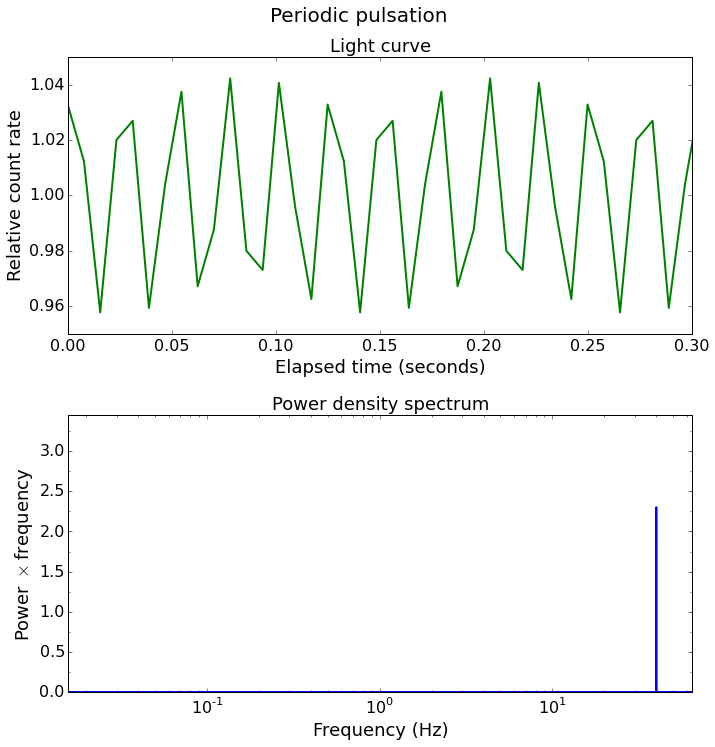

dt = 0.0078125000000 s
df = 0.02 Hz
nyquist = 64.00 Hz
n_bins = 8192


In [24]:
super_title_pulse = "Periodic pulsation"

npn_pulse = pulse_power[1:] * pos_freq[1:]
# npn_pulse = pulse_power[1:]

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))
fig.suptitle(super_title_pulse, fontsize=20, y=1.03)

ax1.plot(time, pulse_lc, linewidth=2.0, color='g')
ax1.set_xlabel('Elapsed time (seconds)', fontproperties=font_prop)
ax1.set_ylabel('Relative count rate', fontproperties=font_prop)
ax1.set_xlim(0, 0.3)
ax1.tick_params(axis='x', labelsize=16, bottom=True, top=True, labelbottom=True, labeltop=False)
ax1.tick_params(axis='y', labelsize=16, left=True, right=True, labelleft=True, labelright=False)
ax1.set_title('Light curve', fontproperties=font_prop)

ax2.plot(pos_freq[1:], npn_pulse, linewidth=2.0)
ax2.set_xlabel('Frequency (Hz)', fontproperties=font_prop)
ax2.set_ylabel(r'Power $\times$ frequency', fontproperties=font_prop)
ax2.set_xscale('log')
ax2.set_xlim(pos_freq[1], nyquist)
# ax2.set_xlim(0,200)
ax2.set_ylim(0, np.max(npn_pulse)+.5*np.max(npn_pulse))
## Setting the y-axis minor ticks. It's complicated.
y_maj_loc = ax2.get_yticks()
y_min_mult = 0.5 * (y_maj_loc[1] - y_maj_loc[0])
yLocator = MultipleLocator(y_min_mult)  ## location of minor ticks on the y-axis
ax2.yaxis.set_minor_locator(yLocator)
ax2.tick_params(axis='x', labelsize=16, bottom=True, top=True, labelbottom=True, labeltop=False)
ax2.tick_params(axis='y', labelsize=16, left=True, right=True, labelleft=True, labelright=False)
ax2.set_title('Power density spectrum', fontproperties=font_prop)

fig.tight_layout(pad=1.0, h_pad=2.0)
plt.show()

print "dt = %.13f s" % dt
print "df = %.2f Hz" % df
print "nyquist = %.2f Hz" % nyquist
print "n_bins = %d" % n_bins

### Summing together the pulsation and the noise (where the noise has a power law, QPO, etc.)

In [25]:
total_lc = pulse_lc * noise_lc
total_lc[np.where(total_lc < 0)] = 0.0
total_lc_poiss = np.random.poisson(total_lc * dt) / dt 
mean_total_lc = np.mean(total_lc_poiss)
print "Mean count rate of light curve:", mean_total_lc

total_unnorm_power = np.absolute(fftpack.fft(total_lc_poiss - mean_total_lc)) ** 2
total_unnorm_power = total_unnorm_power[0:len(pos_freq)]
total_power = 2.0 * total_unnorm_power * dt / float(n_bins) / (mean_total_lc ** 2)
total_power -= 2.0 / mean_total_lc
print "Mean of total power:", np.mean(total_power)

total_pow_var = np.sum(total_power * df)

## Re-binning the power spectrum in frequency
rb_freq, rb_total_power, tfreq_min, tfreq_max = geometric_rebinning(pos_freq, total_power, 1.01)


Mean count rate of light curve: 494.3125
Mean of total power: 0.000135770940721


### Plotting the periodic pulsation + noise process: light curve and power spectrum.

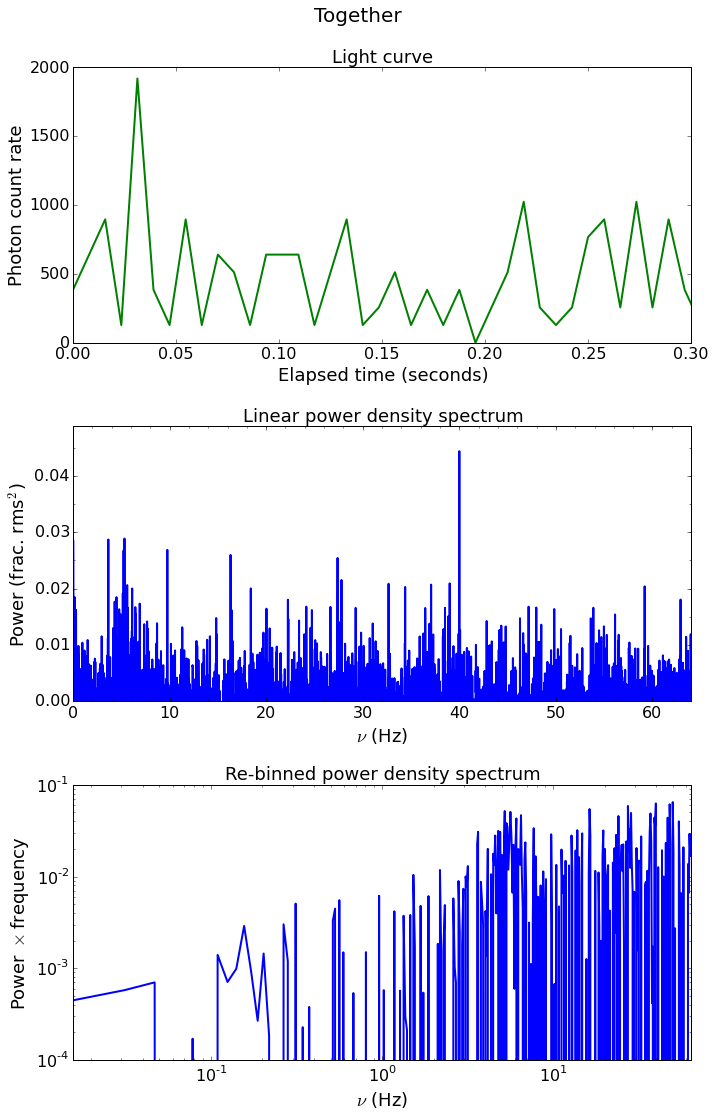

dt = 0.0078125000000 s
df = 0.02 Hz
nyquist = 64.00 Hz
n_bins = 8192
power variance = 8.69e-03 (frac rms2)


In [26]:
super_title_total = "Together"

npn_total = rb_total_power * rb_freq
# npn_total = total_power

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,15))
fig.suptitle(super_title_total, fontsize=20, y=1.03)

## Plotting the light curve
ax1.plot(time, total_lc_poiss, linewidth=2.0, color='g')
ax1.set_xlabel('Elapsed time (seconds)', fontproperties=font_prop)
ax1.set_ylabel('Photon count rate', fontproperties=font_prop)
ax1.set_xlim(0, 0.3)
ax1.set_ylim(0,)
ax1.tick_params(axis='x', labelsize=16, bottom=True, top=True, labelbottom=True, labeltop=False)
ax1.tick_params(axis='y', labelsize=16, left=True, right=True, labelleft=True, labelright=False)
ax1.set_title('Light curve', fontproperties=font_prop)

## Linearly plotting the power spectrum
ax2.plot(pos_freq, total_power, linewidth=2.0)
ax2.set_xlabel(r'$\nu$ (Hz)', fontproperties=font_prop)
ax2.set_ylabel(r'Power (frac. rms$^{2}$)', fontproperties=font_prop)
ax2.set_xlim(0, nyquist)
ax2.set_ylim(0, np.max(total_power) + (0.1 * np.max(total_power)))
## Setting the axes' minor ticks. It's complicated.
x_maj_loc = ax2.get_xticks()
y_maj_loc = ax2.get_yticks()
x_min_mult = 0.2 * (x_maj_loc[1] - x_maj_loc[0])
y_min_mult = 0.5 * (y_maj_loc[1] - y_maj_loc[0])
xLocator = MultipleLocator(x_min_mult)  ## location of minor ticks on the y-axis
yLocator = MultipleLocator(y_min_mult)  ## location of minor ticks on the y-axis
ax2.xaxis.set_minor_locator(xLocator)
ax2.yaxis.set_minor_locator(yLocator)
ax2.tick_params(axis='x', labelsize=16, bottom=True, top=True, labelbottom=True, labeltop=False)
ax2.tick_params(axis='y', labelsize=16, left=True, right=True, labelleft=True, labelright=False)
ax2.set_title('Linear power density spectrum', fontproperties=font_prop)

## Logaritmically plotting the re-binned power * frequency spectrum
ax3.plot(rb_freq, npn_total, linewidth=2.0)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel(r'$\nu$ (Hz)', fontproperties=font_prop)
ax3.set_ylabel(r'Power $\times$ frequency', fontproperties=font_prop)
ax3.set_xlim(0, nyquist)
# ax3.set_xlim(4000,)
# ax3.set_ylim(0,300)
ax3.tick_params(axis='x', labelsize=16, bottom=True, top=True, labelbottom=True, labeltop=False)
ax3.tick_params(axis='y', labelsize=16, left=True, right=True, labelleft=True, labelright=False)
ax3.set_title('Re-binned power density spectrum', fontproperties=font_prop)

fig.tight_layout(pad=1.0, h_pad=2.0)
plt.show()

print "dt = %.13f s" % dt
print "df = %.2f Hz" % df
print "nyquist = %.2f Hz" % nyquist
print "n_bins = %d" % n_bins
print "power variance = %.2e (frac rms2)" % total_pow_var

### Playing around with other stuff

In [27]:
##  Titles in unicode
# print u"\n\t\tPower law; \u03B2 = %s\n" % str(beta)
# print u"\n\t\tLorentzian; \u0393 = %s at \u03C9\u2080 = %s\n" % (str(gamma), str(w_0))
# print u"\n\t\tPower law with exponential decay; \u03B2 = %s, \u03B1 = %s\n" \
#     % (str(beta), str(alpha))
# print u"\n\n\tBroken power law; \u03C9_break = %s, \u03B2\u2081 = %s, \u03B2\u2082 = %s\n" \
#     % (str(w_b), str(beta_1), str(beta_2))

# super_title = r"Power law with exponential decay: $\beta$ = %s, $\alpha$ = %s" % (str(beta), str(alpha))
# super_title = r"Broken power law; $\omega_{break}$ = %.2f Hz, $\beta_1$ = %.2f, $\beta_2$ = %.2f" \
#     % (w_b, beta_1, beta_2)
